### Исследование влияния пандемии на криминальную структуру Чикаго

In [330]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [331]:
sns.set_style('darkgrid')

In [332]:
from google.cloud import bigquery

In [333]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=r"C:\Users\idmak\Documents\University_projects\service-account-file.json"

In [334]:
client = bigquery.Client()

In [335]:
crimes_tab = client.query("""
SELECT year, primary_type, COUNT(unique_key) AS total
FROM bigquery-public-data.chicago_crime.crime
GROUP BY year, primary_type
HAVING((year=2019 or year=2020) AND total >= 20)
""").result().to_dataframe().set_index(keys=['primary_type','year']).T
crimes_tab['CRIMINAL SEXUAL ASSAULT']+=crimes_tab['CRIM SEXUAL ASSAULT']
crimes_tab = crimes_tab.T.drop(index='CRIM SEXUAL ASSAULT')

c:\users\idmak\appdata\local\programs\python\python38\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [336]:
arrested = client.query("""
SELECT year, primary_type, COUNT(unique_key) AS arrested
FROM bigquery-public-data.chicago_crime.crime
WHERE (arrest = True)
AND primary_type NOT IN
(SELECT primary_type FROM bigquery-public-data.chicago_crime.crime
GROUP BY primary_type,year HAVING(COUNT(unique_key)<20 AND (YEAR = 2019 OR YEAR = 2020)))
GROUP BY year, primary_type
HAVING((year=2019 or year=2020))
""").result().to_dataframe().set_index(keys=['primary_type','year']).T
arrested['CRIMINAL SEXUAL ASSAULT']+=arrested['CRIM SEXUAL ASSAULT']
arrested = arrested.T.drop(index='CRIM SEXUAL ASSAULT')

In [337]:
domestic = client.query("""
SELECT year, primary_type, COUNT(unique_key) AS domestic
FROM bigquery-public-data.chicago_crime.crime
WHERE domestic = True
AND primary_type NOT IN
(SELECT primary_type FROM bigquery-public-data.chicago_crime.crime
GROUP BY primary_type,year HAVING(COUNT(unique_key)<20 AND (YEAR = 2019 OR YEAR = 2020)))
GROUP BY year, primary_type
HAVING(year=2019 or year=2020)
""").result().to_dataframe().set_index(keys=['primary_type','year']).T
domestic['CRIMINAL SEXUAL ASSAULT']+=domestic['CRIM SEXUAL ASSAULT']
domestic = domestic.T.drop(index='CRIM SEXUAL ASSAULT')

In [338]:
crimes = crimes_tab.join([arrested, domestic],how='outer')

In [339]:
crimes['perc_arrested'] = round(crimes.arrested/crimes.total,2)
crimes['perc_domestic'] = round(crimes.domestic/crimes.total,2)

Статистика по преступлениях каждого типа в зависимости от года

In [342]:
crimes.head(3)

total  arrested  domestic  perc_arrested  perc_domestic
primary_type year                                                         
ARSON        2019    375        42      20.0           0.11           0.05
             2020    586        39      23.0           0.07           0.04
ASSAULT      2019  20617      3741    5283.0           0.18           0.26

Посчитаем и визуализируем некоторые статистики по годам:

In [408]:
stats_by_year = crimes.groupby(level=1).aggregate({'total': ['sum','median'],'perc_arrested': 'median',
                                                  'perc_domestic': 'median'}).reset_index()
stats_by_year

year   total         perc_arrested perc_domestic
            sum  median        median        median
0  2019  260771  1619.0          0.18          0.05
1  2020  211269  1270.0          0.13          0.07

In [344]:
v = crimes.reset_index().sort_values(by='total',ascending=False)
v.head(3)

,primary_type,year,total,arrested,domestic,perc_arrested,perc_domestic
50,THEFT,2019,62452,6108,2355.0,0.10,0.04
4,BATTERY,2019,49508,10392,23858.0,0.21,0.48
5,BATTERY,2020,41485,6869,21522.0,0.17,0.52


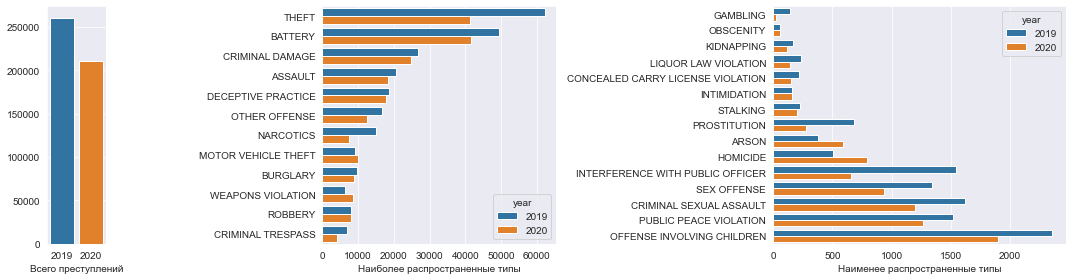

In [413]:
fig,axes = plt.subplots(1,3,figsize=(15,4),gridspec_kw={'width_ratios': [0.1, 0.4,0.5]})
sns.barplot(data=stats_by_year,x='year',y=stats_by_year.columns[1],ax=axes[0]).set(xlabel=None,ylabel=None)
sns.barplot(data=v.head(24),x='total',y='primary_type',hue='year',orient='h',ax=axes[1]).set(xlabel=None,ylabel=None)
sns.barplot(data=v.sort_values(by='total').head(30),x='total',y='primary_type',hue='year',orient='h',ax=axes[2]).set(xlabel=None,ylabel=None)
axes[0].set_xlabel('Всего преступлений')
axes[1].set_xlabel('Наиболее распространенные типы')
axes[2].set_xlabel('Наименее распространенные типы')
plt.tight_layout()
plt.savefig("total_stats")

In [346]:
names=['Всего преступлений','Процент арестованных','Процент совершенных знакомыми']

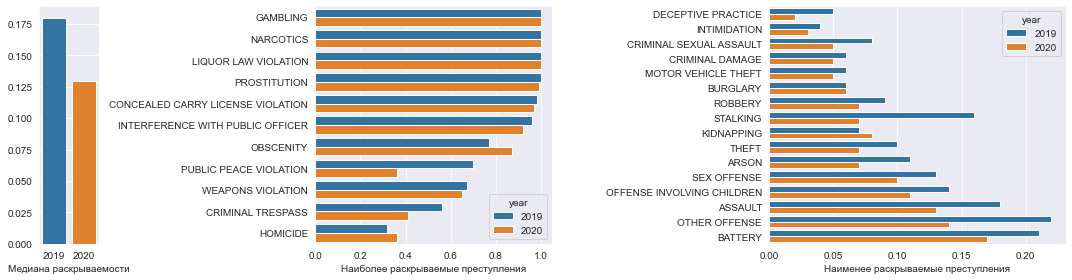

In [347]:
fig,axes = plt.subplots(1,3,figsize=(15,4),gridspec_kw={'width_ratios': [0.1,0.4,0.5]})
sns.barplot(data=stats_by_year,x='year',y=stats_by_year.columns[3],ax=axes[0]).set(xlabel=None,ylabel=None)
sns.barplot(data=v.sort_values(by='perc_arrested',ascending=False).\
                               head(22),x='perc_arrested',y='primary_type',hue='year',orient='h',ax=axes[1]).set(xlabel=None,ylabel=None)
sns.barplot(data=v.sort_values(by='perc_arrested',ascending=True).\
                               head(32),x='perc_arrested',y='primary_type',hue='year',orient='h',ax=axes[2]).set(xlabel=None,ylabel=None)
axes[0].set_xlabel('Медиана раскрываемости')
axes[1].set_xlabel('Наиболее раскрываемые преступления')
axes[2].set_xlabel('Наименее раскрываемые преступления')
plt.tight_layout()


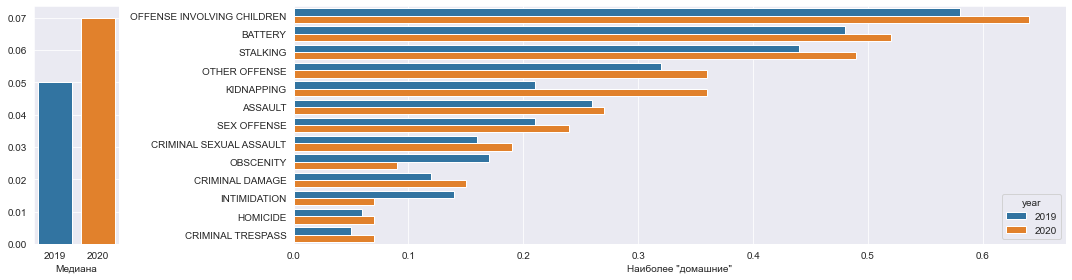

In [348]:
fig,axes = plt.subplots(1,2,figsize=(15,4),gridspec_kw={'width_ratios': [0.1,0.9]})
sns.barplot(data=stats_by_year,x='year',y=stats_by_year.columns[4],ax=axes[0]).set(xlabel=None,ylabel=None)
sns.barplot(data=v.sort_values(by='perc_domestic',ascending=False).\
                               head(26),x='perc_domestic',y='primary_type',hue='year',orient='h',ax=axes[1]).set(xlabel=None,ylabel=None)
axes[0].set_xlabel('Медиана')
axes[1].set_xlabel('Наиболее "домашние"')
plt.tight_layout()

In [349]:
cat_table = crimes.unstack().iloc[:,[0,1,6,7,8,9]]
cat_table.columns = [2019,2020]*3
cat_table.head()

,2019,2020,2019,2020,2019,2020
primary_type,,,,,,
ARSON,375,586,0.11,0.07,0.05,0.04
ASSAULT,20617,18248,0.18,0.13,0.26,0.27
BATTERY,49508,41485,0.21,0.17,0.48,0.52
BURGLARY,9638,8744,0.06,0.06,0.02,0.02
CONCEALED CARRY LICENSE VIOLATION,217,148,0.98,0.97,NaN,NaN


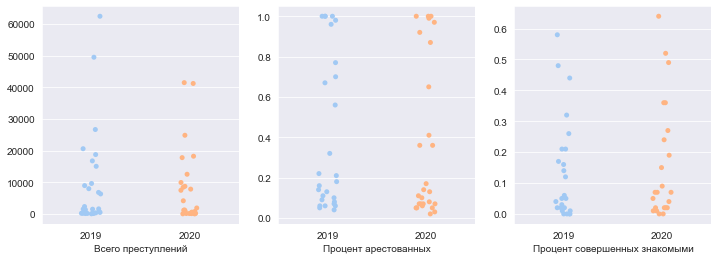

In [350]:
fig,axes = plt.subplots(1,3,figsize=(12,4))
for i in range(3):
    sns.stripplot(data=cat_table.iloc[:,2*i:2*i+2],ax=axes[i],palette='pastel');
    axes[i].set_xlabel(names[i])

Загрузим данные по количеству преступлений в зависимости от типа и района по 2019 и 2020 годам:

In [351]:
crimes_distr_2019_tab = client.query("""
SELECT district, primary_type, COUNT(unique_key) AS total
FROM bigquery-public-data.chicago_crime.crime
WHERE (year = 2019) AND (district != 31)
AND primary_type NOT IN
(SELECT primary_type FROM bigquery-public-data.chicago_crime.crime
GROUP BY primary_type,year HAVING(COUNT(unique_key)<20 AND (YEAR = 2019 OR YEAR = 2020)))
GROUP BY district, primary_type
""").result().to_dataframe()

In [352]:
crimes_distr_2020_tab = client.query("""
SELECT district, primary_type, COUNT(unique_key) AS total
FROM bigquery-public-data.chicago_crime.crime
WHERE year = 2020 AND (district != 31)
AND primary_type NOT IN
(SELECT primary_type FROM bigquery-public-data.chicago_crime.crime
GROUP BY primary_type,year HAVING(COUNT(unique_key)<20 AND (YEAR = 2019 OR YEAR = 2020)))
GROUP BY district, primary_type
""").result().to_dataframe()

In [353]:
crimes_distr_2019 = crimes_distr_2019_tab.pivot_table(index='district',columns='primary_type', values='total',
                                                 fill_value=0)
crimes_distr_2019['CRIMINAL SEXUAL ASSAULT']+=crimes_distr_2019['CRIM SEXUAL ASSAULT']
crimes_distr_2019 = crimes_distr_2019.drop(columns='CRIM SEXUAL ASSAULT');

In [354]:
crimes_distr_2019.head(3)

primary_type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,GAMBLING,...,OBSCENITY,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,PROSTITUTION,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
district,,,,,,,,,,,,,,,,,,,,,
1,2,882,1776,162,6,765,58,555,2087,1,...,4,26,528,0,91,366,53,12,7345,51
2,6,988,2294,308,3,1120,70,258,780,1,...,8,104,942,11,51,360,62,15,2649,233
3,12,1174,3062,595,9,1477,97,302,618,4,...,1,167,948,1,70,453,56,15,2060,324


In [355]:
crimes_distr_2020 = crimes_distr_2020_tab.pivot_table(index='district',columns='primary_type', values='total',
                                                 fill_value=0)
crimes_distr_2020['CRIMINAL SEXUAL ASSAULT']+=crimes_distr_2020['CRIM SEXUAL ASSAULT']
crimes_distr_2020 = crimes_distr_2020.drop(columns=['CRIM SEXUAL ASSAULT']);

In [356]:
crimes_distr_2020.head(3)

primary_type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,GAMBLING,...,OBSCENITY,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,PROSTITUTION,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
district,,,,,,,,,,,,,,,,,,,,,
1,19,530,1220,374,1,639,50,315,1006,0,...,1,22,324,2,88,289,30,5,2748,182
2,17,934,1884,298,3,1118,49,132,822,0,...,3,98,721,9,99,336,35,18,1856,298
3,25,1120,2648,516,0,1538,60,176,602,0,...,2,132,693,0,68,390,32,9,1615,553


### Изменения по количеству преступлений

Воспользуемся t-критерием Стьюдента для проверки значимости изменений по типам преступлений

In [357]:
from scipy.stats import shapiro, ttest_ind, levene

Отберем признаки, имеющие нормальное распределение с помощью критерия Шапиро-Уилка:

In [358]:
norm_2019 = set()
for col in crimes_distr_2019:
    if shapiro(crimes_distr_2019[col])[1]>0.01:
        norm_2019.add(col)

In [359]:
norm_2020 = set()
for col in crimes_distr_2020:
    if shapiro(crimes_distr_2020[col])[1]>0.01:
        norm_2020.add(col)

In [360]:
print(norm_2019.difference(norm_2020))
print(norm_2020.difference(norm_2019))

{'INTIMIDATION'}
{'PUBLIC PEACE VIOLATION', 'DECEPTIVE PRACTICE', 'THEFT', 'CONCEALED CARRY LICENSE VIOLATION'}


In [361]:
normal_columns = norm_2019.intersection(norm_2020)

In [362]:
changed_total = []
for col in normal_columns:
    if levene(crimes_distr_2020[col],crimes_distr_2019[col])[1]>0.05:
        t_val = ttest_ind(crimes_distr_2020[col],crimes_distr_2019[col], equal_var=True)[1]
        if t_val < 0.025 or t_val>1-0.025:
            changed_total.append(col)
    else:
        t_val = ttest_ind(crimes_distr_2020[col],crimes_distr_2019[col], equal_var=False)[1]
        if t_val < 0.025 or t_val>1-0.025:
            changed_total.append(col)

Типы преступлений, показавшие значимые изменения в 2020 году:

In [363]:
changed_total

['CRIMINAL SEXUAL ASSAULT',
 'OTHER OFFENSE',
 'SEX OFFENSE',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'ARSON',
 'CRIMINAL TRESPASS']

In [364]:
df1 = pd.DataFrame(crimes_distr_2019[changed_total].mean()).assign(year=2019).reset_index().rename(columns={0: 'total'})
df2 = pd.DataFrame(crimes_distr_2020[changed_total].mean()).assign(year=2020).reset_index().rename(columns={0: 'total'})
total_changed_to_plot = pd.concat([df1,df2]).reset_index().drop(columns='index')

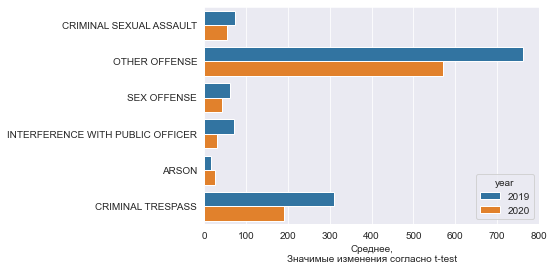

In [365]:
sns.barplot(data=total_changed_to_plot, x='total',y='primary_type',hue='year')\
                            .set(xlabel='Среднее,\nЗначимые изменения согласно t-test',
                                 ylabel=None);

Для типов, не имеющих нормальное распределение, воспользуемся критерием Уилкоксона

In [366]:
from scipy.stats import wilcoxon

In [367]:
not_normal_columns = crimes_distr_2020.columns.difference(normal_columns)

In [368]:
changed_total = []
for col in not_normal_columns:
    w_val = wilcoxon(crimes_distr_2019[col],y=crimes_distr_2020[col], mode='approx')[1]
    if w_val < 0.005 or w_val > 0.995:
        changed_total.append(col)

In [369]:
df1 = pd.DataFrame(crimes_distr_2019[changed_total].sum()).assign(year=2019).reset_index().rename(columns={0: 'total'})
df2 = pd.DataFrame(crimes_distr_2020[changed_total].sum()).assign(year=2020).reset_index().rename(columns={0: 'total'})
total_changed_to_plot = pd.concat([df1,df2]).reset_index().drop(columns='index')

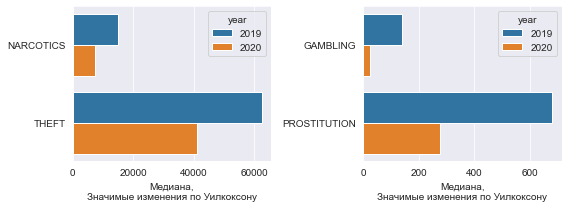

In [370]:
fig, axes = plt.subplots(1,2,figsize=(8,3))
sns.barplot(data=total_changed_to_plot.query('total>1000')
            , x='total',y='primary_type',hue='year', ax=axes[0]).set(xlabel='Медиана,\nЗначимые изменения по Уилкоксону'
                                                                     ,ylabel=None)
sns.barplot(data=total_changed_to_plot.query('total<1000')
            , x='total',y='primary_type',hue='year', ax=axes[1]).set(xlabel='Медиана,\nЗначимые изменения по Уилкоксону'
                                                                     ,ylabel=None);
plt.tight_layout()

### Изменения в раскрываемости 

In [371]:
crimes_distr_2019_arrested_tab = client.query("""
SELECT district, primary_type, COUNT(unique_key) AS total
FROM bigquery-public-data.chicago_crime.crime
WHERE year = 2019 AND arrest = TRUE AND (district != 31)
AND primary_type NOT IN
(SELECT primary_type FROM bigquery-public-data.chicago_crime.crime
GROUP BY primary_type,year HAVING(COUNT(unique_key)<20 AND (YEAR = 2019 OR YEAR = 2020)))
GROUP BY district, primary_type
""").result().to_dataframe()

In [372]:
crimes_distr_2020_arrested_tab = client.query("""
SELECT district, primary_type, COUNT(unique_key) AS total
FROM bigquery-public-data.chicago_crime.crime
WHERE year = 2020 AND arrest = TRUE AND (district != 31)
AND primary_type NOT IN
(SELECT primary_type FROM bigquery-public-data.chicago_crime.crime
GROUP BY primary_type,year HAVING(COUNT(unique_key)<20 AND (YEAR = 2019 OR YEAR = 2020)))
GROUP BY district, primary_type
""").result().to_dataframe()

In [373]:
crimes_distr_2019_arrested = crimes_distr_2019_arrested_tab.pivot_table(index='district',columns='primary_type', values='total',
                                                 fill_value=0)
crimes_distr_2019_arrested['CRIMINAL SEXUAL ASSAULT']+=crimes_distr_2019_arrested['CRIM SEXUAL ASSAULT']
crimes_distr_2019_arrested = crimes_distr_2019_arrested.drop(columns='CRIM SEXUAL ASSAULT');

In [374]:
crimes_distr_2019_arrested.head(3)

primary_type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,GAMBLING,...,OBSCENITY,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,PROSTITUTION,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
district,,,,,,,,,,,,,,,,,,,,,
1,0,157,409,15,6,60,2,314,123,1,...,4,8,43,0,43,78,7,1,961,35
2,1,125,445,8,2,60,1,132,29,1,...,6,7,167,11,32,17,3,2,208,106
3,3,190,565,14,9,90,5,188,28,4,...,1,18,181,1,47,20,5,2,129,219


In [375]:
crimes_distr_2019_arrested_perc = round(crimes_distr_2019_arrested/crimes_distr_2019,2)
for i in crimes_distr_2019_arrested_perc.columns[crimes_distr_2019_arrested_perc.isnull().any(axis=0)]:
    crimes_distr_2019_arrested_perc[i].fillna(crimes_distr_2019_arrested_perc[i].mean(),inplace=True)

In [376]:
crimes_distr_2020_arrested = crimes_distr_2020_arrested_tab.pivot_table(index='district',columns='primary_type', values='total',
                                                 fill_value=0)
crimes_distr_2020_arrested['CRIMINAL SEXUAL ASSAULT']+=crimes_distr_2020_arrested['CRIM SEXUAL ASSAULT']
crimes_distr_2020_arrested = crimes_distr_2020_arrested.drop(columns='CRIM SEXUAL ASSAULT');

In [377]:
crimes_distr_2020_arrested.head(3)

primary_type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,GAMBLING,...,OBSCENITY,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,PROSTITUTION,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
district,,,,,,,,,,,,,,,,,,,,,
1,3,85,302,33,1,59,5,164,38,0,...,1,4,29,2,40,51,7,1,405,158
2,2,90,250,14,2,45,2,42,14,0,...,3,3,83,9,15,14,2,3,73,136
3,0,117,356,13,0,66,2,70,15,0,...,2,9,74,0,22,16,3,0,78,308


In [378]:
crimes_distr_2020_arrested_perc = round(crimes_distr_2020_arrested/crimes_distr_2020,2)
for i in crimes_distr_2020_arrested_perc.columns[crimes_distr_2020_arrested_perc.isnull().any(axis=0)]:
    crimes_distr_2020_arrested_perc[i].fillna(crimes_distr_2020_arrested_perc[i].mean(),inplace=True)

In [379]:
norm_2019_ar = set()
for col in crimes_distr_2019_arrested_perc:
    if shapiro(crimes_distr_2019_arrested_perc[col])[1]>0.01:
        norm_2019_ar.add(col)

c:\users\idmak\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [380]:
norm_2020_ar = set()
for col in crimes_distr_2020_arrested_perc:
    if shapiro(crimes_distr_2020_arrested_perc[col])[1]>0.01:
        norm_2020_ar.add(col)

In [381]:
normal_columns_ar = norm_2020_ar.intersection(norm_2019_ar)

In [382]:
changed_perc_ar=[]
for col in normal_columns_ar:
    if levene(crimes_distr_2020_arrested_perc[col],crimes_distr_2019_arrested_perc[col])[1]>0.05:
        t_val = ttest_ind(crimes_distr_2020_arrested_perc[col],crimes_distr_2019_arrested_perc[col], equal_var=True)[1]
        if(t_val < 0.025 or t_val > 0.975):
            changed_perc_ar.append(col)
    else:
        t_val = ttest_ind(crimes_distr_2020_arrested_perc[col],crimes_distr_2019_arrested_perc[col], equal_var=False)[1]
        if(t_val < 0.025 or t_val > 0.975):
            changed_perc_ar.append(col)

c:\users\idmak\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\morestats.py:2603: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


In [383]:
df3 = pd.DataFrame(crimes_distr_2019_arrested_perc[changed_perc_ar].mean()).assign(year=2019).reset_index().rename(columns={0: 'perc'})
df4 = pd.DataFrame(crimes_distr_2020_arrested_perc[changed_perc_ar].mean()).assign(year=2020).reset_index().rename(columns={0: 'perc'})
perc_ar_changed_to_plot = pd.concat([df3,df4]).reset_index().drop(columns='index')

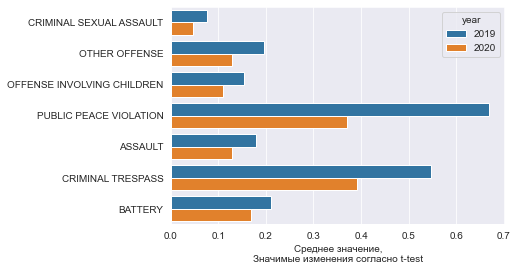

In [384]:
sns.barplot(data=perc_ar_changed_to_plot, x='perc',y='primary_type',hue='year')\
                                                    .set(xlabel='Среднее значение,\nЗначимые изменения согласно t-test',ylabel=None);

In [385]:
not_normal_columns_ar = crimes_distr_2020_arrested_perc.columns.difference(normal_columns_ar)

In [386]:
changed_perc_ar = []
for col in not_normal_columns_ar:
    w_val = wilcoxon(crimes_distr_2019_arrested_perc[col],y=crimes_distr_2020_arrested_perc[col],mode='approx')[1]
    if w_val < 0.005 or w_val > 0.995:
        changed_perc_ar.append(col)

c:\users\idmak\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [387]:
df3 = pd.DataFrame(crimes_distr_2019_arrested_perc[changed_perc_ar].median()).assign(year=2019).reset_index().rename(columns={0: 'perc'})
df4 = pd.DataFrame(crimes_distr_2020_arrested_perc[changed_perc_ar].median()).assign(year=2020).reset_index().rename(columns={0: 'perc'})
perc_ar_changed_to_plot = pd.concat([df3,df4]).reset_index().drop(columns='index')

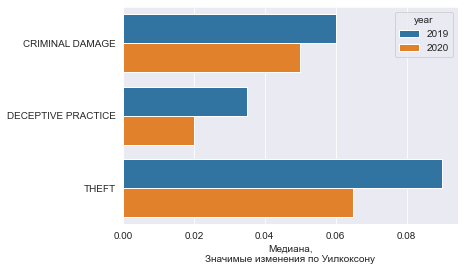

In [388]:
sns.barplot(data=perc_ar_changed_to_plot, x='perc',y='primary_type',hue='year')\
                                        .set(xlabel='Медиана,\nЗначимые изменения по Уилкоксону'
                                                                                    ,ylabel=None);

#### ИЗМЕНЕНИЯ В  "ДОМАШНИХ" ПРЕСТУПЛЕНИЙ

In [389]:
crimes_distr_2019_domestic_tab = client.query("""
SELECT district, primary_type, COUNT(unique_key) AS total
FROM bigquery-public-data.chicago_crime.crime
WHERE year = 2019 AND domestic = TRUE AND (district != 31)
AND primary_type NOT IN
(SELECT primary_type FROM bigquery-public-data.chicago_crime.crime
GROUP BY primary_type,year HAVING(COUNT(unique_key)<20 AND (YEAR = 2019 OR YEAR = 2020)))
GROUP BY district, primary_type
""").result().to_dataframe()

In [390]:
crimes_distr_2019_domestic = crimes_distr_2019_domestic_tab.pivot_table(index='district',columns='primary_type', values='total',
                                                 fill_value=0)
crimes_distr_2019_domestic['CRIMINAL SEXUAL ASSAULT']+=crimes_distr_2019_domestic['CRIM SEXUAL ASSAULT']
crimes_distr_2019_domsetic = crimes_distr_2019_domestic.drop(columns='CRIM SEXUAL ASSAULT');

In [391]:
crimes_distr_2019_domestic.head(3)

primary_type,ARSON,ASSAULT,BATTERY,BURGLARY,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,HOMICIDE,...,OBSCENITY,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,PROSTITUTION,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
district,,,,,,,,,,,,,,,,,,,,,
1,0,82,370,3,2,29,3,4,7,0,...,0,12,147,0,1,1,5,7,36,0
2,0,235,1137,8,5,169,6,16,8,2,...,3,48,324,0,1,10,11,6,131,1
3,1,329,1786,14,15,260,23,17,12,5,...,0,87,357,0,2,15,18,8,196,2


In [392]:
crimes_distr_2020_domestic_tab = client.query("""
SELECT district, primary_type, COUNT(unique_key) AS total
FROM bigquery-public-data.chicago_crime.crime
WHERE year = 2020 AND domestic = TRUE AND (district != 31)
AND primary_type NOT IN
(SELECT primary_type FROM bigquery-public-data.chicago_crime.crime
GROUP BY primary_type,year HAVING(COUNT(unique_key)<20 AND (YEAR = 2019 OR YEAR = 2020)))
GROUP BY district, primary_type
""").result().to_dataframe()

In [393]:
crimes_distr_2020_domestic = crimes_distr_2020_domestic_tab.pivot_table(index='district',columns='primary_type', values='total',
                                                 fill_value=0)
crimes_distr_2020_domestic['CRIMINAL SEXUAL ASSAULT']+=crimes_distr_2020_domestic['CRIM SEXUAL ASSAULT']
crimes_distr_2020_domsetic = crimes_distr_2020_domestic.drop(columns='CRIM SEXUAL ASSAULT');

In [394]:
crimes_distr_2020_domestic.head(3)

primary_type,ARSON,ASSAULT,BATTERY,BURGLARY,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,HOMICIDE,...,NARCOTICS,OBSCENITY,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
district,,,,,,,,,,,,,,,,,,,,,
1,0,61,343,0,0,20,8,5,2,0,...,0,0,15,78,0,2,1,3,41,0
2,1,222,960,8,0,169,8,12,11,4,...,1,0,55,261,0,2,8,12,122,2
3,0,327,1556,23,0,316,12,17,4,3,...,0,0,72,277,2,28,8,8,199,2


In [395]:
crimes_distr_2019_domestic_perc = round(crimes_distr_2019_domsetic/crimes_distr_2019,2)
for i in crimes_distr_2019_domestic_perc.columns[crimes_distr_2019_domestic_perc.isnull().any(axis=0)]:
    crimes_distr_2019_domestic_perc[i].fillna(crimes_distr_2019_domestic_perc[i].mean(),inplace=True)

In [396]:
crimes_distr_2020_domestic_perc = round(crimes_distr_2020_domsetic/crimes_distr_2020,2)
for i in crimes_distr_2020_domestic_perc.columns[crimes_distr_2020_domestic_perc.isnull().any(axis=0)]:
    crimes_distr_2020_domestic_perc[i].fillna(crimes_distr_2020_domestic_perc[i].mean(),inplace=True)

In [397]:
norm_2019_dom = set()
for col in crimes_distr_2019_domestic_perc:
    if shapiro(crimes_distr_2019_domestic_perc[col])[1]>0.01:
        norm_2019_dom.add(col)

c:\users\idmak\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [398]:
norm_2020_dom = set()
for col in crimes_distr_2020_domestic_perc:
    if shapiro(crimes_distr_2020_domestic_perc[col])[1]>0.01:
        norm_2020_dom.add(col)

In [399]:
normal_columns_dom = norm_2020_dom.intersection(norm_2019_dom)

In [400]:
changed_perc_dom=[]
for col in normal_columns_dom:
    if levene(crimes_distr_2020_domestic_perc[col],crimes_distr_2019_domestic_perc[col])[1]>0.05:
        t_val = ttest_ind(crimes_distr_2020_domestic_perc[col],crimes_distr_2019_domestic_perc[col], equal_var=True)[1]
        if(t_val < 0.025 or t_val > 0.975):
            changed_perc_dom.append(col)
    else:
        t_val = ttest_ind(crimes_distr_2020_domestic_perc[col],crimes_distr_2019_domestic_perc[col], equal_var=False)[1]
        if(t_val < 0.025 or t_val > 0.975):
            changed_perc_dom.append(col)

In [401]:
df5 = pd.DataFrame(crimes_distr_2019_domestic_perc[changed_perc_dom].mean()).assign(year=2019).reset_index().rename(columns={0: 'perc'})
df6 = pd.DataFrame(crimes_distr_2020_domestic_perc[changed_perc_dom].mean()).assign(year=2020).reset_index().rename(columns={0: 'perc'})
perc_dom_changed_to_plot = pd.concat([df5,df6]).reset_index().drop(columns='index')

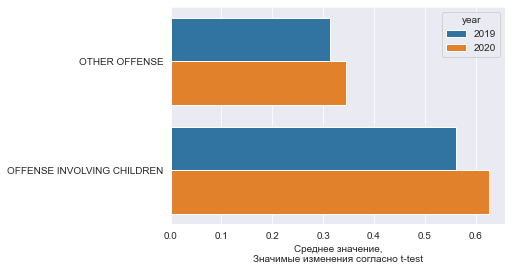

In [402]:
sns.barplot(data=perc_dom_changed_to_plot, x='perc',y='primary_type',hue='year')\
                                                    .set(xlabel='Среднее значение,\nЗначимые изменения согласно t-test',ylabel=None);

In [403]:
not_normal_columns_dom = crimes_distr_2020_domestic_perc.columns.difference(normal_columns_dom)
not_normal_columns_dom = set(not_normal_columns_dom).difference\
(['PROSTITUTION','CONCEALED CARRY LICENCE VIOLATION','LIQUOR LAW VIOLATION'])

In [404]:
changed_perc_dom = []
for col in not_normal_columns_dom:
    w_val = wilcoxon(crimes_distr_2019_domestic_perc[col],y=crimes_distr_2020_domestic_perc[col],mode='approx')[1]
    if w_val < 0.005 or w_val > 0.995:
        changed_perc_dom.append(col)

c:\users\idmak\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [405]:
df7 = pd.DataFrame(crimes_distr_2019_domestic_perc[changed_perc_dom].mean()).assign(year=2019).reset_index().rename(columns={0: 'perc'})
df8 = pd.DataFrame(crimes_distr_2020_domestic_perc[changed_perc_dom].mean()).assign(year=2020).reset_index().rename(columns={0: 'perc'})
perc_dom_changed_to_plot = pd.concat([df7,df8]).reset_index().drop(columns='index')

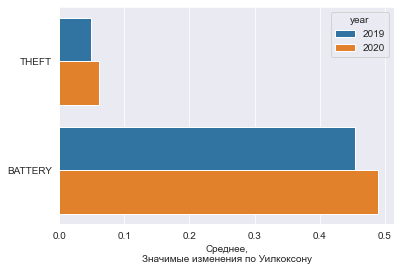

In [406]:
sns.barplot(data=perc_dom_changed_to_plot, x='perc',y='primary_type',hue='year')\
                                        .set(xlabel='Среднее,\nЗначимые изменения по Уилкоксону'
                                                                                    ,ylabel=None);